In [1]:
import random
import operator

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv as csv
#import pygraphviz as pg

In [3]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [4]:
from inspect import isclass
import scipy


In [5]:
#########################################################################
# TITANIC INPUT DATA
#########################################################################

train_data=[] # Create a bin to hold our training data.
test_data=[]  # Create a bin to hold our test data.


In [6]:
# Read in CSVs, train and test

with open('train.csv', 'r') as f1:
    f1.readline()
    for row in  csv.reader(f1):       # Skip through each row in the csv file
        train_data.append(row)        # Add each row to the data variable
    train_data = np.array(train_data) # Then convert from a list to a NumPy array

with open('test.csv', 'r') as f2:
    f2.readline()
    for row in csv.reader(f2):      # Skip through each row in the csv file
        test_data.append(row)       # Add each row to the data variable
    test_data = np.array(test_data) # Then convert from a list to an array


In [7]:
# Convert strings to numbers so we can perform computational analysis    
# The gender classifier in column 3: Male = 1, female = 0:
train_data[train_data[0::,3] == 'male', 3] = 1
train_data[train_data[0::,3] == 'female', 3] = 0

In [8]:
# Embark C = 0, S = 1, Q = 2
train_data[train_data[0::,10] == 'C', 10] = 0
train_data[train_data[0::,10] == 'S', 10] = 1
train_data[train_data[0::,10] == 'Q', 10] = 2

In [9]:
# Transfer Null observations
# So where there is no price, I will assume price on median of that class
# Where there is no age I will give median of all ages

# All the ages with no data make the median of the data
train_data[train_data[0::,4] == '',4] = np.median(train_data[train_data[0::,4]\
                                           != '',4].astype(np.float))
# All missing embarks just make them embark from most common place
train_data[train_data[0::,10] == '',10] = np.round(np.mean(train_data[train_data[0::,10]\
                                                   != '',10].astype(np.float)))

train_data = np.delete(train_data,[2,7,9],1) #remove the name data, cabin and ticket
# I need to do the same with the test data now so that the columns are in the same
# as the training data

# I need to convert all strings to integer classifiers:
# male = 1, female = 0:
test_data[test_data[0::,2] == 'male',2] = 1
test_data[test_data[0::,2] == 'female',2] = 0

In [10]:
# Embark C = 0, S = 1, Q = 2
test_data[test_data[0::,9] == 'C',9] = 0
test_data[test_data[0::,9] == 'S',9] = 1
test_data[test_data[0::,9] =='Q',9] = 2

# All the ages with no data make the median of the data
test_data[test_data[0::,3] == '',3] = np.median(test_data[test_data[0::,3] != '',3].astype(np.float))
# All missing embarks just make them embark from most common place
test_data[test_data[0::,9] == '',9] = np.round(np.median(test_data[test_data[0::,9] != '',9].astype(np.float)))
# All the missing prices assume median of their respective class
for i in range(np.size(test_data[0::,0])):
    if test_data[i,7] == '':
        test_data[i,7] = np.median(test_data[(test_data[0::,7] != '') &\
                                             (test_data[0::,0] == test_data[i,0])\
            ,7].astype(np.float))

test_data = np.delete(test_data,[1,6,8],1) # Remove the name data, cabin and ticket


random.seed(0)
titanic_x = train_data[0::,1::]
titanic_x = titanic_x.astype(float)
titanic_x = titanic_x / titanic_x.max(axis=0)
titanic_y = train_data[0::,0]

In [11]:
# split into train and test sets
ind = int(len(titanic_x) * .8)
train_x = titanic_x[:ind]
train_y = titanic_y[:ind]
test_x = titanic_x[ind:]
test_y = titanic_y[ind:]

In [12]:
##############################################################################

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)


In [13]:
def inverse(x):
    if abs(float(x)) < 1e-9:
        return 1
    return np.power(float(x), -1)

pset = gp.PrimitiveSet("MAIN", arity=7)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addPrimitive(np.negative, arity=1)
pset.addPrimitive(inverse, arity=1)
pset.renameArguments(ARG0='Pclass')
pset.renameArguments(ARG1='Sex')
pset.renameArguments(ARG2='Age')
pset.renameArguments(ARG3='SibSp')
pset.renameArguments(ARG4='Parch')
pset.renameArguments(ARG5='Fare')
pset.renameArguments(ARG6='Embarked')

In [14]:
pset.addEphemeralConstant("const", lambda: random.randint(-10, 10))

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


In [15]:
# Combine tournament with NSGA2
def my_select(population, k):
    population = tools.selNSGA2(population, len(population))
    return tools.selTournamentDCD(population, k)


In [16]:
def mutShrink(individual):
    ##This operator shrinks the *individual* by chosing randomly a branch and
    ##replacing it with one of the branch's arguments (also randomly chosen).
    ##:param individual: The tree to be shrinked.
    ##:returns: A tuple of one tree.
    
    # We don't want to "shrink" the root
    
    if len(individual) < 3 or individual.height <= 1:
        return individual,
    
    iprims = []
    for i, node in enumerate(individual[1:], 1):
        if isinstance(node, Primitive) and node.ret in node.args:
            iprims.append((i, node))
            
    if len(iprims) != 0:
        index, prim = random.choice(iprims)
        arg_idx = random.choice([i for i, type_ in enumerate(prim.args) 
                                 if type_ == prim.ret])
        rindex = index + 1
        for _ in range(arg_idx + 1):
            rslice = individual.searchSubtree(index)
            individual[slice_] = subtree
            
    return individual,

In [17]:
def evalSymbReg(individual, x, y, pset):
    func = gp.compile(expr=individual, pset=pset)
    r = []
    for z in x:

        a = func(float(z[0]), float(z[1]), float(z[2]),float(z[3]),float(z[4]),float(z[5]),float(z[6]))
        r.append(a)
    results = [0 if m > 0 else 1 for m in r]
    fp = 0
    fn = 0
    for t in zip(results, y):
        if t[0] != int(t[1]):
            if int(t[1]):
                fp += 1
            else:
                fn += 1

    return (fp, fn)

In [18]:
toolbox.register("evaluate", evalSymbReg, x=titanic_x, y=titanic_y, pset=pset)
toolbox.register("select", my_select)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)


In [19]:
from multiprocessing import Pool

if __name__ == '__main__':
    pool = Pool()
    toolbox.register('map', pool.map)

    #toolbox.register()

    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

    gen = range(100)
    avg_list = []
    max_list = []
    min_list = []
    avg_list2 = []
    max_list2 = []
    min_list2 = []
pop = toolbox.population(n=1000)

In [20]:
# Evaluate the entire population
fitnesses = list(toolbox.map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

    #probList = [2.0 / 14, 4.0 / 14, 2.0 / 14, 1.0 / 14, 2.0 / 14, 1.0 / 14, 2.0 / 14]
    #choices = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

    p1 = 0.25
    p2 = 0.3

    #keep track of all our pareto areas
    paretoAreaList = []


In [21]:
# Begin the evolution
for g in gen:
    print("-- Generation %i --" % g)
    p1 -= .0015
    p2 -= .0015
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(toolbox.map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
            for mutant in offspring:
                indRange = len(mutant)
                if random.random() < p1:
                    #toolbox.mutate(mutant)
                    if indRange <= 10: #bloat control
                        location = random.randint(1,indRange - 1)
                        subtree_slice = mutant.searchSubtree(location)
                        ind = gp.genHalfAndHalf(pset=pset, min_=1, max_=2)
                        mutant[subtree_slice] = ind[:]
                        del mutant.fitness.values
                        ##if random.random() < p2:
                            ##if indRange < 10: #bloat control
                                ##mutShrink(mutant)
                                ##del mutant.fitness.values



-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

In [22]:
# Evaluate the individuals with an invalid fitness
invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit


In [23]:
# Replace population
pop[:] = offspring
# Gather all the fitnesses in one list and print the stats
fits = [ind.fitness.values[0] for ind in pop]
length = len(pop)
mean = sum(fits) / length
sum2 = sum(x*x for x in fits)
std = abs(sum2 / length - mean**2)**0.5
g_max = max(fits)
g_min = min(fits)

avg_list.append(mean)
max_list.append(g_max)
min_list.append(g_min)

print("  Min %s" % g_min)
print("  Max %s" % g_max)
print("  Avg %s" % mean)
print("  Std %s" % std)

  Min 0.0
  Max 342.0
  Avg 157.011
  Std 137.30906335344366


In [24]:
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[1] for ind in pop]

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        g_max = max(fits)
        g_min = min(fits)

        avg_list2.append(mean)
        max_list2.append(g_max)
        min_list2.append(g_min)
        print("  Min %s" % g_min)
        print("  Max %s" % g_max)
        print("  Avg %s" % mean)
        print("  Std %s" % std)

  Min 0.0
  Max 549.0
  Avg 291.81
  Std 236.67274008639018


In [25]:
print("-- End of (successful) evolution --")
best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

worst_ind = tools.selWorst(pop, 1)[0]
print("Worst individual is %s, %s" % (worst_ind, worst_ind.fitness.values))

a_given_individual = toolbox.population(n=1)[0]
a_given_individual.fitness.values = toolbox.evaluate(a_given_individual)


-- End of (successful) evolution --
Best individual is inverse(subtract(subtract(inverse(add(Pclass, Parch)), add(Pclass, Embarked)), inverse(multiply(Pclass, Fare)))), (0.0, 544.0)
Worst individual is subtract(subtract(inverse(add(Age, SibSp)), multiply(Pclass, SibSp)), add(add(multiply(Parch, Age), Parch), Fare)), (342.0, 9.0)


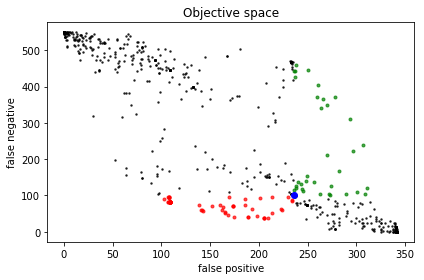

In [26]:
def pareto_dominance(ind1, ind2):
    not_equal = False
    for value_1, value_2 in zip(ind1.fitness.values, ind2.fitness.values):
        if value_1 > value_2:
            return False
        elif value_1 < value_2:
            not_equal = True
    return not_equal

dominated = [ind for ind in pop if pareto_dominance(a_given_individual, ind)]
dominators = [ind for ind in pop if pareto_dominance(ind, a_given_individual)]
others = [ind for ind in pop if not ind in dominated and not ind in dominators]
    
for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', alpha=0.7)
for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', alpha=0.7)
for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.7, ms=3)
plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], 'bo', ms=6);
plt.xlabel('false positive');
plt.ylabel('false negative');
plt.title('Objective space');
plt.tight_layout()
plt.show()

In [27]:
def predict(individual, x, pset):
        func = gp.compile(expr=individual, pset=pset)
        r = []
        for z in x:

            a = func(float(z[0]), float(z[1]), float(z[2]),float(z[3]),float(z[4]),float(z[5]),float(z[6]))
            r.append(a)
        results = [0 if m > 0 else 1 for m in r]
        return results

In [28]:
def accuracy(individual, x, y, pset):
        func = gp.compile(expr=individual, pset=pset)
        r = []
        for z in x:

            a = func(float(z[0]), float(z[1]), float(z[2]),float(z[3]),float(z[4]),float(z[5]),float(z[6]))
            r.append(a)
        results = [0 if m > 0 else 1 for m in r]
        correct = 0
        for t in zip(results, y):
            if t[0] == int(t[1]):
                correct+=1

        return (correct) / len(y)


In [29]:
    paretoFront = tools.ParetoFront()

    paretoFront.update(pop)

    x = []
    y = []
    for ind in paretoFront:
        x.append(ind.fitness.values[0])
        y.append(ind.fitness.values[1])

    paretoArea = np.trapz(np.asarray(y), np.asarray(x))
    print("The pareto area is %d" %paretoArea)


The pareto area is 35121


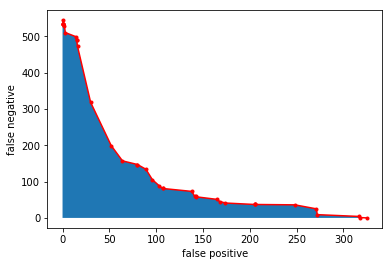

38
individual is inverse(subtract(subtract(inverse(add(Pclass, Parch)), add(Pclass, Embarked)), inverse(multiply(Pclass, Fare)))), (0.0, 544.0)
38
individual is subtract(subtract(subtract(Sex, inverse(multiply(Age, 1))), negative(Embarked)), Fare), (2.0, 527.0)
38
individual is subtract(multiply(Pclass, Embarked), add(multiply(negative(Sex), Pclass), inverse(Parch))), (30.0, 318.0)
38
individual is inverse(subtract(subtract(subtract(Sex, Parch), multiply(Age, multiply(add(-8, Pclass), multiply(Pclass, Parch)))), Pclass)), (103.0, 89.0)
38
individual is negative(subtract(add(add(Fare, Fare), subtract(multiply(inverse(Embarked), Fare), Sex)), Parch)), (143.0, 58.0)
38
individual is subtract(multiply(Sex, add(subtract(Pclass, Embarked), add(Pclass, Sex))), negative(SibSp)), (205.0, 37.0)


In [30]:
#for ind in paretoFront: plt.plot(ind.fitness.values[0], ind.fitness.values[1], '.r-', alpha=0.7, ms=3)
plt.plot(x, y, '.r-')
d = scipy.zeros(len(y))
plt.fill_between(x, y, where=y>d)


plt.xlabel('false positive')
plt.ylabel('false negative')
plt.show()
for i in range(6):
    print(len(paretoFront))
    ind = paretoFront[int(len(paretoFront)/6*i)]
    print("individual is %s, %s" % (ind, ind.fitness.values))
    nodes, edges, labels = gp.graph(ind)